# B-Spline

In [1]:
# Based on the notes
# INTEREST RATES AND FX MODELS: 1. LIBOR and OIS
# by Andrew Lesniewski

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook

from bspline import BSpline

A B-spline of degree $d\geq 0$ is a function $f(t)$ of the form
$$
    f(t) = \sum_{-\infty \leq k \leq \infty} f_k B_k ^{(d)}(t)
$$

Where we define, for a sequence of knot points $\{t_k\}_{- \infty \leq k \leq \infty}$

$$B_k^{(0)}(t) =
    \begin{cases}
    1 & t_k \leq t < t_{k+1} \\
    0 & \text{otherwise}
    \end{cases}
$$

And, recursively, for $d\geq 1$,
$$
   B_k^{(d)}(t) = \frac{t - t_k}{t_{k+d} - t_k} B_k^{(d-1)}(t) + \frac{t_{k+d+1} - t}{t_{k+d+1} - t_{k+1}} B_{k+1}^{(d-1)}(t)
$$

In [2]:
knots = np.array([-3, -2, 0, 1, 3, 6])
bspline = BSpline(knots, 3)

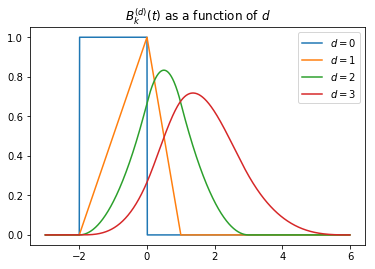

In [3]:
T = np.arange(-3, 6, 0.01)

for d in range(4):
    plt.plot(T, bspline.keval(T, 1, d), label="$d={}$".format(d))
    
plt.legend()
plt.title(r"$B_k^{(d)}(t)$ as a function of $d$")
plt.show()

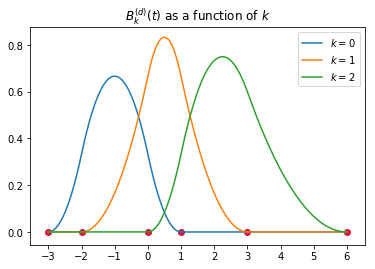

In [3]:
degree = 2
bs1 = BSpline(knots, degree)

for k in range(3):
    plt.plot(T, bs1.keval(T, k), label="$k={}$".format(k))
plt.scatter(bs1.knots, np.zeros(len(bs1.knots)), c="crimson")
plt.legend()
plt.xticks(range(-3,7))
plt.title(r"$B_k^{(d)}(t)$ as a function of $k$")
plt.show()

#### B-Spline Derivative
For the derivative we have the following recursion
$$
    \frac{d}{dt}B_{d}^{k}(t) = \frac{d}{t_{k+d} - t_k}B_{d-1}^{k}(t) - \frac{d}{t_{k+d+1} - t_{k+1}}B_{d-1}^{k+1}(t)
$$



In [4]:
bspline.diff(1, 1)

0.23333333333333331

#### B-Spline Integration
The integral from $-\infty$ to $t$ can be expressed in terms of a sum as follows:
$$
    \int_{-\infty}^{t} B_k^{(d)}(s) ds = \sum_{i=k}^{\infty}\frac{t_{k+d+1}- t_k}{d + 1}B_i^{(d+1)}(t)
$$

Where we require at least $d + 2$ knot points greater than or equal to $t$

In [6]:
knots = np.array([-3, -2, 0, 1, 3, 6])
bspline.integrate(0, 1)

0.90208333333333346

### Playing with B-Splines
If we have $6$ knots, modifying $f_k$ for all $k=0,\ldots, 5$ creates an instance of
$$
f(t) = \sum_{k} f_k B_k ^{(d)}(t)
$$

In [163]:
from ipywidgets import interact, FloatSlider
from numpy import vectorize

knots = np.array([-3, -2, 0, 1, 3, 6, 7, 8])
bspline = BSpline(knots, 3)

@vectorize
def BSpline_Eval(x, *args):
    coefs = args
    return np.sum([coefs[ix] * bspline.keval(x, k, out_bounds_eval=True)
                   for ix, k in enumerate(bspline.knots)])

def plot_bspline(**kwargs):
    args = list(kwargs.values())
    X = np.linspace(-3, 5)
    Y = BSpline_Eval(X, *args)
    plt.plot(X, Y)
    plt.show()

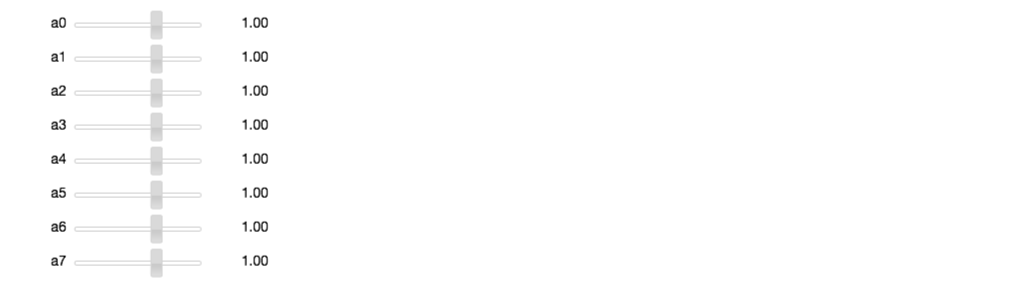

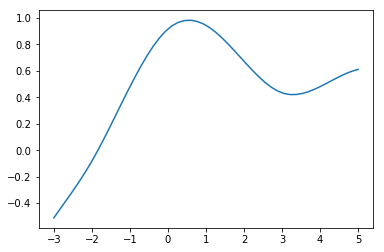

<function __main__.plot_bspline>

In [164]:
interact(plot_bspline,
         a0 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a1 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a2 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a3 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a4 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a5 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a6 = FloatSlider(value=1, min=-1, max=2, step=0.1),
         a7 = FloatSlider(value=1, min=-1, max=2, step=0.1))

# Curve construction by B-splines ﬁtting

To value a mid-market swap:
$$
    P_0^{fix} = P_0^{float}.
$$

Implies
$$
    \sum_{j=1}^{n_c}C\cdot \iota_j\cdot P_0(t, T_j^c) = \sum_{j=1}^{n_f}L_0(T_{j-1}^f, T_j^f)\cdot \upsilon_j\cdot P_0(t, T_j^c)
$$

Where:
1. $\iota_i$ and $\upsilon_i$ denote the day count fractions for the fixed and floating legs respectively;
2. $P_0(S,T)$ denotes the discount factor

Consider $C$ to be the coupon of a **mid-market swap**. In that case,
$$
    C = \frac{\sum_{j=1}^{n_f}L_0(T_{j-1}^f, T_j^f)\cdot \upsilon_j\cdot P_0(t, T_j^c)}
             {\sum_{j=1}^{n_c}\cdot \iota_j\cdot P_0(t, T_j^c)}
$$

Then, we would like to find $C$ such that
$$
    C - \frac{\sum_{j=1}^{n_f}L_0(T_{j-1}^f, T_j^f)\cdot \upsilon_j\cdot P_0(t, T_j^c)}
             {\sum_{j=1}^{n_c}\cdot \iota_j\cdot P_0(t, T_j^c)}  = 0
$$

Where we define

$$
    P_0(S, T) = \exp\left(-\sum_{k=-3}^N \gamma_k(S,T) \cdot f_k\right)
$$

$$
    L_0(S, T) = \frac{1}{\tau}\left(-\exp\left(\sum_{k=-3}^{N}\gamma_k(S,T) \cdot l_k\right)-1\right)
$$

and $\gamma_k(S,T) := \int_S^TB_k(s) ds$.

In [110]:
nx1_instruments = np.array([1, 3, 6, 9, 13, 26, 39, 52, 65, 91, 130, 156, 195, 260, 390])
mid_mkt = np.array([0.0409 ,  0.04315,  0.0446 ,  0.046  ,  0.04765,  0.05035,
                    0.05245,  0.0543 ,   0.05605,  0.05905,  0.06215,  0.06401,
                    0.0668 ,  0.06911,  0.07142])

coefs = np.ones(len(nx1_instruments))
bspline = BSpline(nx1_instruments, 3)

In [19]:
f_factors = np.ones(bspline.len_knots)
bspline.integrate_coef(f_factors, nx1_instruments)

array([  0.00000000e+00,   5.00000000e-02,   1.44442935e+00,
         4.96330463e+00,   1.09062968e+01,   3.20267207e+01,
         5.41637597e+01,   7.84568452e+01,   1.07717510e+02,
         1.69521161e+02,   2.60284821e+02,   3.28566250e+02,
         3.14453125e+02,   7.82407407e+01,   0.00000000e+00])

In [181]:
nflows = np.array([28, 84, 169, 252, 364, 728, 1092, 1456, 1820, 2548, 3640, 4368, 5460, 7280, 10920])